<h1>K-Means Clustering Tutorial</h1>

This is a tutorial to implement the K-Means algorithm for 2D data sets in Python. It may not be efficient or perfect, but it should be a great start to springboard off and implement your own improvements. Feel free to distribute, edit, make changes, improve, etc. If you publish it elsewhere, let me know and link back!

<h2>K-Means</h2>

The K-Means algorithm is often used as a demonstration of unsupervised learning. There are other spaces where K-Means is used, such as data mining and cluster analysis, but I want to focus strictly on the machine learning space.

Supervised learning, to be succinct, is a machine learning technique where you have <i>complete data</i>: for each example of data, you know the attributes and the class of the example. For unsupervised learning, however, you have <i>incomplete data</i>, namely you do not know an example's class nor how many classes you may have in a set of data. K-Means tries to address the incomplete data by determining where the classes lie in the working space and to a lesser extent, how many classes exist.

K-Means follows the below procedure:

```
procedure k-means(integer k) is:
  load data into the space
  initialize k centroids within the space
  for each epoch do:
    for each point p of data do:
      find the nearest centroid c to p
      consider p "belonging" to c
    endfor
    for each centroid c do:
      find the mean position m of all points "belonging" to c
      reposition c to m
    endfor
  endfor
endprocedure
```

The general idea is centroids will move to where many points exist, but not too close to each other. Membership of each centroid will change with each epoch, and given enough epochs, each centroid will be centered on a cluster of data. Provided `k` is optimal, the idealized outcome is every cluster of point contains one centroid, and the classification of clusters can be applied to each data point. Therein lies the primary purpose: identify classes of data.

The problem with this algorithm is it presupposed an optimal `k`: if a data set were to contain three clusters but a `k=4` is chosen, some clusters will have multiple centroids. Later I will discuss a way to determine an optimal `k`, but for now let's assume `k` is known. It also depends on <i>good initialization</i> of centroids. Even with an optimal `k`, it doesn't guarantee a good output. This will also be addressed later.

<h2>Before You Begin</h2>

This tutorial uses Python and a couple of dependencies which need to be met:

- Python 3.6
- GNU/Linux (or WSL, LXSS, etc)
- X11 or alternative (eg. xming)
- `pandas`
- `matplotlib`
- some data

I leave it as an exercise to the reader on how to acquire these. I will, however, be using the `S1` set as found <a href="http://cs.joensuu.fi/sipu/datasets/">here</a> to demonstrate the use of the algorithm. I use this set because separation of clusters is good and to visualize where clusters lie is easy. Really, though, you could use any 2D data set (for example, `S2`, `S3`, `S4` on the same page are similar to `S1` but with less cluster separation).

<h2>Starting with Data</h2>

Before the algorithm can be implemented, a means to load and display the data should be made: using `pandas`, it is trivial to load data, although we won't be using `pandas` for much beyond this. There are some Python standard libraries which can do much the same but it's much simpler using `pandas`. We also need a way to containerize the data, as it will become cumbersome to keep track of a dictionary:

In [1]:
class Point:
    """Point class.
    Containerizes an x,y-coordinate.
    
    Attributes:
        x : the x-coordinate of the point.
        y : the y-coordinate of the point.
        c : the cluster the point is a member of.
    """
    
    def __init__(self, x, y):
        """Point constructor."""
        # initially a point has no cluster membership
        self.x, self.y, self.c = x, y, None
    
    def set_coordinate(self, x, y):
        """x,y-coordinate mutator method."""
        self.x, self.y = x, y
    
    def get_coordinate(self):
        """x,y-coordinate accessor method."""
        return self.x, self.y
    
    def set_cluster(self, c):
        """cluster mutator method."""
        self.c = c
    
    def get_cluster(self):
        """cluster accessor method."""
        return self.c
    
    def __eq__(self, other):
        """Equality operation overload method."""
        return self.x == other.x and self.y == other.y
    
    def __neq__(self, other):
        """Inequality operation overload method."""
        return not self.__eq__(other)

Now data can be instantiated as a `Point`. Then we can load the data and display it:

In [2]:
import pandas as pd
import matplotlib.pyplot as plt

def load_data(file):
    """Loads data from file and generates lists of point co-ordinates.
    
    Parameters:
        file : the filename where data is stored.
    
    Returns:
        A list of points.
    """
    # load the data into a pandas dataframe with column names 'x' and 'y'
    df = pd.read_csv(file, names=['x', 'y'], delimiter=r'\s+')
    points = [] # list of points
    for _, d in df.iterrows(): # for each row in the data
        points.append(Point(d['x'], d['y'])) # append to the list of points
    return points

def plot_data(points):
    """Plots data.
    
    Parameters:
        points : a list of points.
    """
    plt.xticks([]); plt.yticks([]) # remove axes tickmarks
    plt.margins(0.05, 0.05) # thin margins
    point_x, point_y = [], [] # lists for coordinates
    for p in points:
        x, y = p.get_coordinate()
        point_x.append(x); point_y.append(y) # add to list of coordinates
    # scatter point at (x, y) with color black, size 2, circular shape
    plt.scatter(point_x, point_y, c='k', s=2, marker='o', lw='1')
    plt.show() # show the plot
    plt.clf() # clear the plot

With the above two functions, data can be loaded into a list of `Point`s, then plotted:

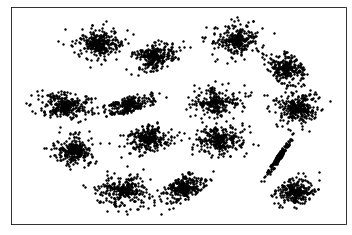

<Figure size 432x288 with 0 Axes>

In [3]:
POINTS = load_data('./data/s1.txt')
plot_data(POINTS)

This is the `S1` set. Visually, you can easily pick out fifteen clusters. However, to a computer, it is not as simple. K-Means attempts to do just this, however, algorithmically, by considering the position of data, distances between data, etc.

<h2>Initializing Centroids</h2>

As previously mentioned, centroids are initialized into the space above. The initialization strategy is important, although the naive approach is to generate centroids at uniformly random positions. We'll do that:

In [4]:
import random

SEED = 5 # will be used repeatedly, keep track of seed

random.seed(SEED)

def initialize_centroids(points, k):
    """Initializes centroids at random positions.
    
    Parameters:
        points : a list of points.
        k : how many centroids to generate.
    
    Returns:
        A list of centroids.
    """
    clusters = [] # a list of centroids
    # the lower and upper bounds for random initialization is needed
    point_x, point_y = [], [] # list for coordinates
    for p in points:
        x, y = p.get_coordinate()
        point_x.append(x); point_y.append(y)
    min_x, max_x = min(point_x), max(point_x)
    min_y, max_y = min(point_y), max(point_y)
    for _ in range(k):
        # get a random coordinate within bounds
        x, y = random.randint(min_x, max_x), random.randint(min_y, max_y)
        clusters.append(Point(x, y)) # a centroid can be just a Point as well
    return clusters

This will place centroids at random within the data space. In order to visualize the centroids, the `plot_data()` function needs to be altered:

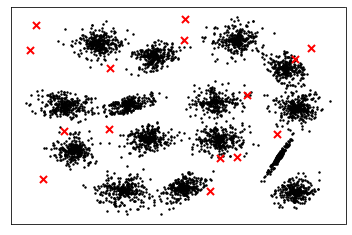

<Figure size 432x288 with 0 Axes>

In [5]:
def plot_data(points, clusters):
    """Plots data.
    
    Parameters:
        points : a list of points.
        clusters : a list of centroids.
    """
    plt.xticks([]); plt.yticks([])
    plt.margins(0.05, 0.05)
    point_x, point_y = [], []
    for p in points:
        x, y = p.get_coordinate()
        point_x.append(x); point_y.append(y)
    plt.scatter(point_x, point_y, c='k', s=2, marker='o', lw='1')
    cluster_x, cluster_y = [], [] # lists for coordinates
    for c in clusters: # for each centroid
        x, y = c.get_coordinate() # get the centroid coordinate
        cluster_x.append(x); cluster_y.append(y)
    # scatter point at (x, y) with color red, shape x
    plt.scatter(cluster_x, cluster_y, c='r', s=50, marker='x', lw='2')
    plt.show()
    plt.clf()

CLUSTERS = initialize_centroids(POINTS, 15) # we know there are 15 clusters
plot_data(POINTS, CLUSTERS)

The centroids were generated and then plotted along with each point. You can see the centroids do not reflect the clusters whatsoever, but that's because the K-Means algorithm hasn't been done yet. Over time, the centroids will move closer and closer to each cluster, hopefully having one centroid per cluster.

<h2>Determining Point Membership</h2>

Determining which centroid a point belongs to is a matter of comparing distances between points and the centroids. There are a few methods, including using euclidean distance metrics, rectilinear distance, etc. For the sake of simplicity, euclidean metrics will be used.

Recall to calculate the distance between two points, $p$ and $q$, using euclidean metric space is as below:

$d_{(p, q)} = \sqrt{(q_x - p_x)^2 + (q_y - p_y)^2}$

By comparing the distances between a point and each cluster, the smallest distance is chosen:

In [6]:
inf = float('inf')
import math

def distance(p, q):
    """Distance calculator using euclidean metrics.
    
    Parameters:
        p : the first point.
        q : the second point.
    
    Returns:
        The distance between p and q.
    """
    (p_x, p_y), (q_x, q_y) = p.get_coordinate(), q.get_coordinate()
    return math.sqrt((q_x - p_x)**2 + (q_y - p_y)**2)

def find_clusters(points, clusters):
    """Determines membership of each point to a cluster.
    
    Parameters:
        points : a list of points.
        clusters : a lit of clusters.
    """
    for p in points:
        best_distance, best_cluster = inf, None
        for c in clusters:
            d = distance(p, c)
            if d < best_distance:
                best_distance, best_cluster = d, c
        p.set_cluster(best_cluster)

Displaying the same plot as before is a little boring, as it doesn't yield any additional information from what was found previously. Instead, we'll color points based on their cluster membership:

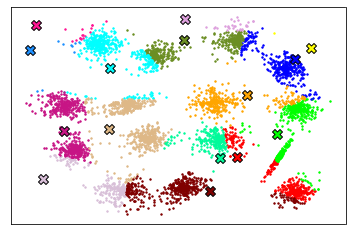

<Figure size 432x288 with 0 Axes>

In [7]:
def plot_data(points, clusters):
    """Plots data.
    
    Parameters:
        points : a list of points.
        clusters : a list of centroids.
    """
    # colors chosen to increase distinction between them
    colors = ['red', 'lime', 'blue', 'yellow', 'orange', 'deeppink', \
        'olivedrab', 'aqua', 'thistle', 'mediumvioletred', 'plum', \
        'burlywood', 'maroon', 'mediumspringgreen', 'dodgerblue', \
        'rebeccapurple', 'lightcoral', 'darkslategrey', 'firebrick', 'bisque', \
        'darkseagreen', 'fuchsia', 'turquoise', 'steelblue', 'chocolate']
    plt.xticks([]); plt.yticks([])
    plt.margins(0.05, 0.05)
    for c, i in zip(clusters, range(len(clusters))): # for each cluster
        point_x, point_y = [], []
        for p in points:
            # ignore points that don't belong to the currently iterated cluster
            if p.get_cluster() is not c:
                continue
            x, y = p.get_coordinate()
            point_x.append(x); point_y.append(y)
            # same as before, but color based on which cluster
        plt.scatter(point_x, point_y, c=colors[i], s=2, marker='o', lw='1')
    cluster_x, cluster_y = [], []
    for c, i in zip(clusters, range(len(clusters))):
        x, y = c.get_coordinate()
        # same as before, but color centroid and leave a black outline
        plt.scatter(x, y, c=colors[i], s=100, marker='X', lw='1', ec='k')
    plt.show()
    plt.clf()

find_clusters(POINTS, CLUSTERS)
plot_data(POINTS, CLUSTERS)

This allows us to see which points belong to which centroid, as well as the position of the centroids themselves. The goal of K-Means is to get the centroids to as close to the cluster centers as possible. An ideal output, colored in this way, wil have each cluster consisting of one color and one centroid.

You can, of course, try other distance measures. Consider the rectilinear (often called manhattan) distance or Chebyshev distance respectively as below:

$d_{(p, q)} = |q_x - p_x| + |q_y - p_y|$

$d_{(p, q)} = \max{(|q_x - p_x|, |q_y - p_y|)}$

For the `S1` set specifically, I found empirically that euclidean metrics performed the best, but it is relatively slow. Consider euclidean distance needs three additions and three exponentiations to compute whereas rectilinear distance needs only three additions. For larger data sets, the difference between metrics in computation time becomes much more apparent, as the algorithm will be performing tens of millions of these calculations.

<h2>Repositioning the Centroids</h2>

The crux of K-Means lies in respositioning the centroids to be closer to cluster centers. To this end, each centroid is moved to the mean position of its member points. First, the mean position of all points belonging to a centroid is found, then the centroid is moved to that coordinate:

In [8]:
def move_centroids(points, clusters):
    """Repositions cluster centroids to the mean position of member points.
    
    Parameters:
        points : a list of points.
        clusters : a list of centroids.
    """
    for c in clusters:
        mean_x, mean_y, count = 0, 0, 0
        for p in points:
            if p.get_cluster() is not c:
                continue
            x, y = p.get_coordinate()
            mean_x += x
            mean_y += y
            count += 1
        new_x, new_y = mean_x/count, mean_y/count
        c.set_coordinate(new_x, new_y)

To see this in action, the centroids are moved five times, membership is reclaulcated, and each step is plotted:

<img src="./images/centroid_reposition.gif" align="left"/>

Note with only three iterations, several centroids have already found their homes at the center of clusters. Of special note is the pale purple to the bottom-left: it pushes away the brown cluster to the right of it. Of concern is the purple cluster at the left, but we'll get to that later.

<h2>The K-Means Algorithm</h2>

Believe it or not, the prior step was essentially K-Means as the functionality is already programmed so far. We just need some kind of driver to perform everything we need:

In [9]:
random.seed(SEED) # reset seed to remain consistent

def k_means(epochs, k):
    """The K-Means algorithm.
    
    Parameters:
        epochs : how many epochs to perform.
        k : how many centroids to generate.
    """
    points = load_data('./data/s1.txt') # load the data
    clusters = initialize_centroids(points, k) # init centroids
    for _ in range(epochs): # perform the algorithm epoch times
        find_clusters(points, clusters) # find membership for each point
        move_centroids(points, clusters) # move centroids
    plot_data(points, clusters) # plot the finished product

This is all that's needed. Running this over enough epochs, the final result is found:

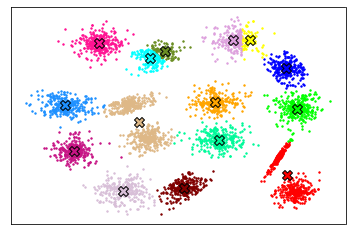

<Figure size 432x288 with 0 Axes>

In [10]:
k_means(15, 15) # 15 epochs, k=15

Well, that's not a particularly nice result, is it? From fifteen clusters, nine were correctly found, two have two clusters belonging to one centroid, and two clusters contain two centroids.

The problem is that K-Means relies on <i>good initialization</i> of centroids to provide a good result. Previously we generated centroids at random, which can work sometimes but often doesn't. It's also data specific: for `S1`, it correctly works perhaps 10% of the time.

There are many initialization strategies, but a popular alternative to random initialization is the K-Means++ initialization strategy.

<h2>K-Means++</h2>

This initialization strategy, rather than placing centroids at random, instead places centroids <i>intelligently</i>. It relies on the distance between points as well as the distance between points and centroids as centroids are found:

```
procedure km++(integer k) is:
  place first centroid at a random position where a point exists
  for 1..k-1 do:
    for each point p in data do:
      find the distance d between p and nearest centroid
    endfor
    place new centroid at position where p is where d is maximized
  endfor
endprocedure
```

Essentially, it finds the largest distance between points where the distance compared is the distance to nearest centroid. It ensures centroids are dispersed well and also coincide with a point's position, thereby guaranteeing the initial centroids are within a cluster to begin with.

You may have noticed with random initialization, some initial centroids are placed outside of a cluster. This is bad for two reasons: it means its closest cluster may already have a centroid within it and it could mean a centroid has no member points. I've chosen my random seed specifically to avoid this, but if you were to try some others, you may encounter a division-by-zero error when repositioning centroids as the number of membership points is zero. K-Means++ prevents this as well.

The algorithm is simple:

In [11]:
def initialize_centroids(points, k):
    """Use K-Means++ initialization strategy to generate centroids.
    
    Parameters:
        points : a list of points.
        k : how many centroids to generate.
    
    Returns:
        A list of centroids.
    """
    clusters = []
    clusters.append(random.choice(points)) # first centroid is random
    for _ in range(k-1): # for other centroids
        distances = [] # to collect distances
        for p in points:
            d = inf
            for c in clusters: # find the minimal distance between p and c
                d = min(d, distance(p, c))
            distances.append(d)
        # find maximal distance index from minimal distances
        clusters.append(points[distances.index(max(distances))])
    return clusters

Rerunning the K-Means driver yields better results:

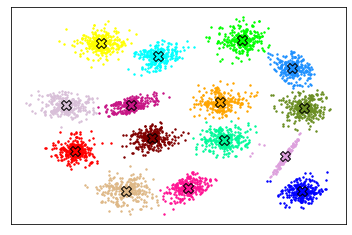

<Figure size 432x288 with 0 Axes>

In [12]:
random.seed(SEED)

k_means(15, 15)

This is the expected perfect case scenario output, where each centroids belongs to one cluster and each cluster has only one centroid. As evidenced, K-Means++ is a better initialization strategy to random initialization, but likewise it is not perfect. While the probability of producing a good K-Means is <i>better</i>, it's still not always. K-Means++ is also relatively slow versus random initialization.

That's how the K-Means algortihm works, but we still haven't addressed how `k` is found. Without visually inspecting the data and counting the number of clusters, you will need to empirically determine `k` before running the algorithm. However, there is a statistic that can be used to quantify how well K-Means performed: the Dunn Index.

<h2>The Dunn Index</h2>

The Dunn Index is a measure of good clustering, where a higher Dunn Index means a better job at clustering. This measure considers how distant centroids are from each other as well as how compact each cluster is. Finding the ratio of these two allows us to compare different values of `k` and determine the best `k` to use for the algorithm. The Dunn Index is as below:

$DI_m = \frac{\min_{1 \leq i \lt j \leq m} \delta (C_i, C_j)}{\max_{1 \leq k \leq m} \Delta k}$

For $m$ clusters, the DI is found by comparing the distance between cluster centroids, choosing the minimal distance, then dividing it by the maximum cluster spread, or diameter. This is found by finding the largest distance between points in a cluster:

In [13]:
def dunn_index(points, clusters):
    """Calculates the Dunn Index of the clustering.
    
    Parameters:
        points : a list of points.
        clusters : a list of clusters.
    
    Returns:
        The Dunn Index of the clustering.
    """
    min_cluster_dist = inf
    # compare distances between cluster centroids, choose smallest
    for c_i in clusters:
        for c_j in clusters:
            if c_i is c_j:
                continue # distance between cluster and itself is 0
            min_cluster_dist = min(min_cluster_dist, distance(c_i, c_j))
    max_cluster_diam = 0
    # compare diameters of each cluster, choose largest
    for c in clusters:
        for p_i in points:
            if p_i.get_cluster() is not c:
                continue # if not in cluster
            for p_j in points:
                if p_j.get_cluster() is not c:
                    continue # if not in cluster
                if p_i is p_j:
                    continue # distance between point and itself is 0
                max_cluster_diam = max(max_cluster_diam, distance(p_i, p_j))
    return round(min_cluster_dist/max_cluster_diam, 4)

The Dunn Index is calculated at the end of the K-Means algorithm, although you could also monitor how the DI changes between epochs. In order to show the DI of the clustering, the K-Means algorithm needs to be slightly changed:

In [14]:
def k_means(epochs, k):
    """The K-Means algorithm.
    
    Parameters:
        epochs : how many epochs to perform.
        k : how many centroids to generate.
    """
    points = load_data('./data/s1.txt')
    clusters = initialize_centroids(points, k)
    for _ in range(epochs):
        find_clusters(points, clusters)
        move_centroids(points, clusters)
    return dunn_index(points, clusters)

Using the same random seed for each run, we can try out different `k` values and compare their Dunn Indices. Recall a higher DI means better clustering:

In [15]:
ys = [] # to store Dunn Indices

for k in range(5, 25+1): # try k-values of 5..25
    random.seed(SEED)
    ys.append(k_means(15, k)) # perform K-Means over 15 epochs with variable k

To make it easier to visualize, we can write a quick plot comparing DI to `k` values:

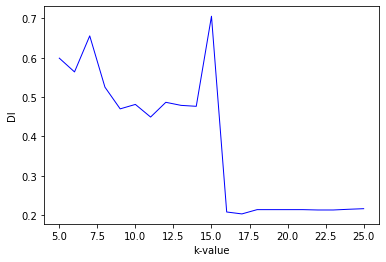

<Figure size 432x288 with 0 Axes>

In [16]:
x = range(5, 25+1)
y = ys
plt.plot(x, y, c='blue', lw='1')
plt.ylabel('DI'); plt.xlabel('k-value')
plt.show()
plt.clf()

This plot describes how well a specific `k` was able to cluster the data. A higher DI indicates better clustering when a lower DI suggests otherwise. You can see the highest point is where `k=15`, which we already knew was the optimal `k`. Interesting is less than fifteen centroids can somewhat cluster the data whereas higher than fifteen is much worse. Even more interesting is that a `k=7` was still close to optimal, perhaps a consequence of each cluster having two-ish centroids, meaning great clustering is possible when `k=7` but optimally `k=15`.

You should recall that even with a good initialization strategy (such as K-Means++), the algorithm is still stochastic and reliant on random number generation in placing the first centroid, thus the Dunn Index, even when the clustering seems good, will be different on each run. There are also times when the clustering is not good (despite nominal `k`), thereby the Dunn Index will reflect this. I've chosen a random seed which produces a good clustering for the purpose of illustration.

For example, using a "bad seed":

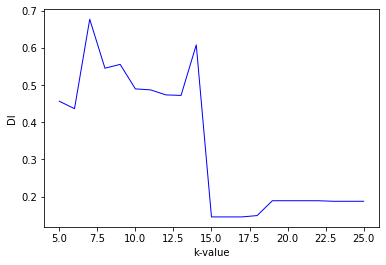

<Figure size 432x288 with 0 Axes>

In [17]:
ys = []

for k in range(5, 25+1):
    random.seed(3)
    ys.append(k_means(15, k))

x = range(5, 25+1)
y = ys
plt.plot(x, y, c='blue', lw='1')
plt.ylabel('DI'); plt.xlabel('k-value')
plt.show()
plt.clf()

Using this seed, the clustering is not particularly good even with the K-Means++ initialization strategy; this plot suggests `k=7` is optimal with `k=15` being the worst (tied with `16`, `17`, `18`), which isn't the case. Since K-Means++ is still stochastic, it won't always yield good clustering and therefore a good Dunn Index. What's interesting, though, is that there is still a very sharp drop off after `k=14`: you could infer that an optimal `k` is at or around this point, where any higher `k` dramatically diminishes the Dunn Index. This is somewhat mirror in the prior plot as well, with a dramatic drop after `k=15`.

For statistical significance, the Dunn Index plots as I have been making should be done over many, many, many runs with different seeds: with enough numbers, the mean Dunn Index plot should show `k=15` as the greatest with clear distinction between optimal and inoptimal `k`.

By using the Dunn Index like this, an optimal `k` can be found for K-Means clustering. It takes some trial and error but you can empirically find the best `k` this way.

<h2>Final Thoughts</h2>

By using K-Means clustering with an appropriate centroid initialization strategy, you can find the classes of data iteratively. Additionally, using the Dunn Index, you can empirically determine an idealized `k` for use in K-Means. This is a simple example of unsupervised learning but works well as a gentle introduction into machine learning.

From this tutorial, you should have learned what K-Means Clustering is, the algorithm and its constituent parts, two initialization strategies (random and K-Means++) as well as how to use the Dunn Index to identify a good `k` parameter.

There are still things you can experiment with: using different distance metrics (rectilinear, Minkowski, Chebyshev, etc) and other initialization strategies. In my experience, using euclidean metrics is the best albeit not the fastest, and K-Means++ is a very good initialization strategy.

As one last thing, here's a complete runthrough of the algorithm showing how it works:

<img src="./images/stepbystep.gif"/>

<h2>Finished Code</h2>

Here is the full code:

In [ ]:
#!/usr/bin/env python3

import pandas as pd
import matplotlib.pyplot as plt
import random
import math

INF = float('inf')
SEED = 5

random.seed(SEED)

class Point:
    def __init__(self, x, y): self.x, self.y, self.c = x, y, None
    def set_coordinate(self, x, y): self.x, self.y = x, y
    def get_coordinate(self): return self.x, self.y
    def set_cluster(self, c): self.c = c
    def get_cluster(self): return self.c
    def __eq__(self, other): return self.x == other.x and self.y == other.y
    def __neq__(self, other): return not self.__eq__(other)

def k_means(epochs):
    points = load_data('./data/s1.txt')
    clusters = initialize_centroids(points, 15)
    for _ in range(epochs):
        find_clusters(points, clusters)
        move_centroids(points, clusters)
    print(f"DI = {dunn_index(points, clusters)}")
    plot_data(points, clusters)

def dunn_index(points, clusters):
    min_cluster_dist = INF
    for c_i in clusters:
        for c_j in clusters:
            if c_i is c_j: continue
            min_cluster_dist = min(min_cluster_dist, distance(c_i, c_j))
    max_cluster_diam = 0
    for c in clusters:
        for p_i in points:
            if p_i.get_cluster() is not c: continue
            for p_j in points:
                if p_j.get_cluster() is not c: continue
                if p_i is p_j: continue
                max_cluster_diam = max(max_cluster_diam, distance(p_i, p_j))
    return round(min_cluster_dist/max_cluster_diam, 4)

def distance(p, q):
    (p_x, p_y), (q_x, q_y) = p.get_coordinate(), q.get_coordinate()
    return math.sqrt((q_x - p_x)**2 + (q_y - p_y)**2)

def find_clusters(points, clusters):
    for p in points:
        best_distance, best_cluster = INF, None
        for c in clusters:
            d = distance(p, c)
            if d < best_distance: best_distance, best_cluster = d, c
        p.set_cluster(best_cluster)

def initialize_centroids(points, k):
    clusters = []
    clusters.append(random.choice(points))
    for _ in range(k-1):
        distances = []
        for p in points:
            d = INF
            for c in clusters: d = min(d, distance(p, c))
            distances.append(d)
        clusters.append(points[distances.index(max(distances))])
    return clusters

def move_centroids(points, clusters):
    for c in clusters:
        mean_x, mean_y, count = 0, 0, 0
        for p in points:
            if p.get_cluster() is not c: continue
            x, y = p.get_coordinate()
            mean_x += x
            mean_y += y
            count += 1
        new_x, new_y = mean_x/count, mean_y/count
        c.set_coordinate(new_x, new_y)

def load_data(file):
    df = pd.read_csv(file, names=['x', 'y'], delimiter=r'\s+')
    points = []
    for _, d in df.iterrows(): points.append(Point(d['x'], d['y']))
    return points

def plot_data(points, clusters):
    colors = ['red', 'lime', 'blue', 'yellow', 'orange', 'deeppink', \
        'olivedrab', 'aqua', 'thistle', 'mediumvioletred', 'plum', \
        'burlywood', 'maroon', 'mediumspringgreen', 'dodgerblue', \
        'rebeccapurple', 'lightcoral', 'darkslategrey', 'firebrick', 'bisque', \
        'darkseagreen', 'fuchsia', 'turquoise', 'steelblue', 'chocolate']
    plt.xticks([]); plt.yticks([])
    plt.margins(0.05, 0.05)
    for c, i in zip(clusters, range(len(clusters))):
        point_x, point_y = [], []
        for p in points:
            if p.get_cluster() is not c: continue
            x, y = p.get_coordinate()
            point_x.append(x); point_y.append(y)
        plt.scatter(point_x, point_y, c=colors[i], s=2, marker='o', lw='1')
    cluster_x, cluster_y = [], []
    for c, i in zip(clusters, range(len(clusters))):
        x, y = c.get_coordinate()
        plt.scatter(x, y, c=colors[i], s=100, marker='X', lw='1', ec='k')
    plt.show()
    plt.clf()

if __name__ == '__main__':
    k_means(15)

You may wish to catch for errors (as I have done none), and perhaps take in a `k` via command line arguments. This should run in a terminal as is but allows for zero option in `k` other than manually editing the code. You can save it as `k-means.py`, and execute it either as `python3 k-means.py` or `./k-means.py`.
You can see a more fleshed out code with comments, error catching, etc <a href="https://github.com/stratzilla/k-means-clustering/">here</a>.